#  의료영상 U-Net 용종검출

4-1.들어가며  

가장 대표적인 딥러닝 모델에는 2015년에 발표된 U-Net: Convolutional Networks for Biomedical Image Segmentation이 있습니다. U-Net은 제목에서도 알수 있듯 Biomedical Image Segmentation에 특화된 모델입니다. 비록 오래되고 단순한 모델 구조를 가지고 있지만, 현재도 여전히 U-Net 기반의 모델들이 용종검출(Polyp segmentation) 들의 챌린지에서 상위그룹의 성적을 내고 있습니다.

오늘은 실제 위내시경 이미지 데이터에서 용종부위를 검출하는 Polyp segmentation 태스크를 U-Net을 비롯한 다양한 모델을 통해 시도해 볼 것입니다. 이 과정을 통해서 의료영상을 처리할 때의 주의사항과 특이사항에 대해서도 경험하게 될 것입니다.
    
    
학습목표   

- 위내시경 이미지에 용종을 표시한 데이터를 이용해 모델을 구성하고, 용종을 찾는 Segmentation 모델을 만들어 본다.  
- 의료이미지 특성상 수가 적은 데이터셋을 활용하기 위한 Data augmentation을 진행해 본다.  
- Encoder-Decoder Model과 U-net 모델을 구현해 보고, U-Net이 일반 Encoder-Decoder 모델 대비 어느정도 성능향상이 되는지 확인해 본다.  
- U-Net에 pretrained encoder를 적용하여 성능개선을 확인해 본다.  

4-2. 데이터 수집 및 Visualization  
의료영상의 특징을 살펴보기 위해 오늘 우리가 다룰 위내시경 용종 데이터셋을 전처리하고 시각화하는 과정을 먼저 진행해 보겠습니다.  

아래와 같이 주요 라이브러리를 로딩해 줍니다.  

In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


데이터 준비
오늘의 프로젝트는 Giana Dataset에서 제공하는 용종 내시경 데이터셋을 이용하여 진행할 것입니다.

오늘 우리가 사용할 영상의 그랜드챌린지 기간이 지났다면 데이터 다운로드가 원활하지 않을 수 있습니다. 그래서 아래 코드를 통해 데이터를 준비해 줍니다.

In [2]:
!mkdir -p ~/aiffel/medical
!ln -s ~/data/* ~/aiffel/medical

ln: failed to create symbolic link '/aiffel/aiffel/medical/ed_ckpt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train_labels': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/unet_ckpt': File exists


Split dataset into train data and test data  
위에서 다운로드한 데이터셋을 학습용과 테스트용으로 분리하겠습니다.   
데이터셋의 이미지와 라벨은 각각 train, train_labels 디렉토리에 분리되어 있고, 쌍을 이루는 이미지와 라벨의 파일명은 동일합니다.  
그리고 사이킷런의 train_test_split을 이용해서 학습(train) 데이터와 테스트(test) 데이터를 분리할 것입니다.  

데이터셋 분리 (학습용과 테스트용)
1. 데이터 경로 설정
DATASET_PATH: 데이터셋의 기본 경로를 설정합니다. 이 경로는 홈 디렉토리 아래에 있는 aiffel/medical입니다.  
img_dir와 label_dir: 학습 이미지(train)와 라벨(train_labels)이 저장된 디렉토리 경로를 설정합니다.  

In [3]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

2. 학습 이미지와 라벨 파일명 목록 생성  
x_train_filenames: 학습 이미지 파일들의 경로를 리스트로 저장합니다.  
y_train_filenames: 학습 라벨 파일들의 경로를 리스트로 저장합니다.  
각 파일 이름을 알파벳 순으로 정렬합니다.  

In [4]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

3. 학습 데이터와 테스트 데이터로 분리  
train_test_split: scikit-learn 라이브러리의 train_test_split 함수를 사용하여 데이터를 학습용(80%)과 테스트용(20%)으로 분리합니다.    
test_size=0.2: 데이터의 20%를 테스트 데이터로 사용한다는 의미입니다.    

In [5]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

4. 데이터 수 확인    
num_train_examples와 num_test_examples: 학습 데이터와 테스트 데이터의 개수를 출력합니다.    


In [7]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


잘 로딩되었나요? 생각보다 이미지 갯수가 많지 않습니다.   
우려가 되지 않으시나요? 과연 이 정도 갯수의 데이터로 모델이 정상적으로 훈련될 수 있을까요?  
그러나 의료영상 처리 분야는 언제든 이렇게 데이터 갯수 부족 문제에 시달려야 할 때가 많을 것입니다. 

Visualization  
데이터 셋에서 이미지 샘플을 5개 정도 살펴봅시다.  

데이터 시각화  
1. 샘플 이미지와 마스크 이미지 표시  

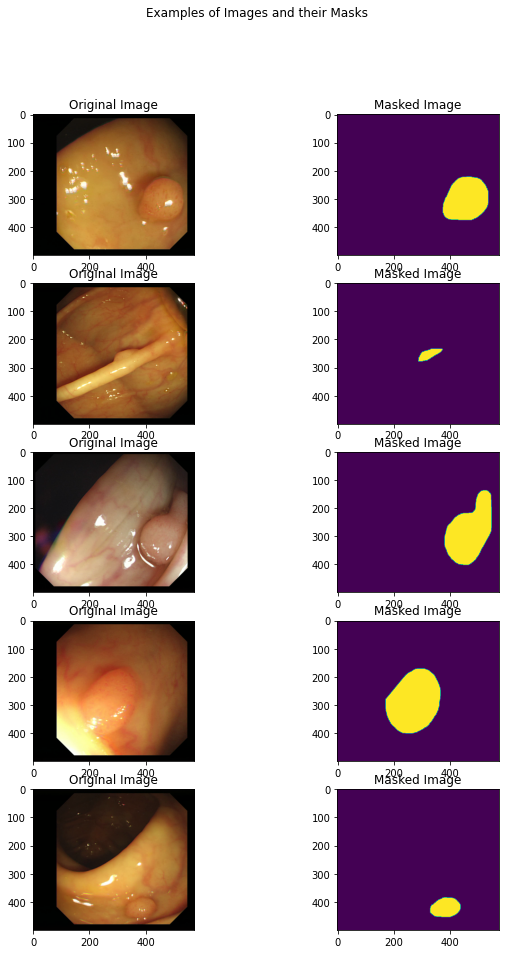

In [8]:
display_num = 5 # 시각화할 이미지와 마스크의 개수를 설정

r_choices = np.random.choice(num_train_examples, display_num) # 학습 데이터에서 임의로 선택한 이미지 인덱스를 저장

plt.figure(figsize=(10, 15)) # 전체 그림 크기를 설정
for i in range(0, display_num * 2, 2): # 선택한 이미지와 대응하는 마스크 이미지를 순서대로 표시
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1) # 여러 개의 이미지를 하나의 플롯에 그리기 위해 사용
    plt.imshow(Image.open(x_pathname)) # 이미지를 플롯에 표시
    plt.title("Original Image") #  각 플롯에 제목을 추가

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks") # 전체 그림의 제목을 설정
plt.show() #  설정된 그림을 화면에 출력

보시는 것처럼 라벨은 클래스 값이 아니라, 입력이미지와 동일한 X-Y 사이즈를 가지고 용종 부위만 표시된 1채널짜리 이미지입니다.     
즉, 우리가 오늘 도전할 태스크는 Image classification이 아니라 Semantic Segmentation이 됩니다.  

4-3. Data pipeline and Preprocessing  
Set up hyper-parameters   
공통적으로 적용될 하이퍼파라미터를 미리 셋팅해 두겠습니다.  

In [9]:
# Set hyperparameters

image_size = 256 # 이미지를 256x256 크기로 조정
img_shape = (image_size, image_size, 3) # 모델에 입력될 이미지의 크기를 정의
batch_size = 8 # 훈련할 때 한 번에 사용할 데이터의 수
max_epochs = 10 # 모델을 학습할 총 반복 횟수

tf.data를 활용한 입력 파이프라인 설계  
오늘 우리는 tf.data.Dataset을 이용해 데이터셋 구축, 배치처리 등을 진행할 것입니다.   
이 과정에서 다양한 함수를 map에 적용하여 Data Augmentation을 함께 구현할 것입니다.   

다음과 같은 과정으로 진행하겠습니다. 이 과정은 tf.data에 대한 텐서플로우 튜토리얼에 소개된 내용을 정리한 것입니다.  
  
1. 이미지와 레이블 모두 파일 이름에서 파일의 바이트를 읽습니다.    
   라벨은 실제로 각 픽셀이 용종데이터로 (1, 0)으로 주석이 달린 이미지입니다.  
2. 바이트를 이미지 형식으로 디코딩합니다.   
3. _augment 함수를 통한 이미지 변환 적용 : (optional, input parameters에 따라서)  
- resize-이미지를 표준 크기로 조정합니다 (eda 또는 계산 / 메모리 제한에 의해 결정됨)  
- resize의 이유는 U-Net이 fully convolution networks 이므로 입력 크기에 의존하지 않기 때문입니다. 그러나 이미지 크기를 조정하지 않으면 가변 이미지 크기를 함께 배치 할 수 없으므로 배치 크기 1을 사용해야합니다.
- 성능에 영향을 줄 수 있으므로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정할 수도 있습니다.    
*hue_delta-RGB 이미지의 색조를 랜덤 팩터로 조정합니다. 이것은 실제 이미지에만 적용됩니다 (라벨 이미지가 아님). hue_delta는[0, 0.5]간격에 있어야합니다.  
*horizontal_flip-0.5 확률로 중심 축을 따라 이미지를 수평으로 뒤집습니다. 이 변환은 레이블과 실제 이미지 모두에 적용해야합니다.  
*width_shift_range 및height_shift_range는 이미지를 가로 또는 세로로 임의로 변환하는 범위 (전체 너비 또는 높이의 일부)입니다. 이 변환은 레이블과 실제 이미지 모두에 적용해야 합니다.  
*rescale-이미지를 일정한 비율로 다시 조정합니다 (예 : 1/255.)    

4. 데이터를 섞고, 데이터를 반복하여 학습합니다.      
  
Data augmentation의 필요성    
Data augmentation은 딥러닝을 이용한 이미지 처리분야 (classification, detection, segmentation 등) 에서 널리 쓰이는 테크닉입니다.   
의료영상 처리와 같이 데이터 갯수가 부족한 경우 이런 기법이 큰 힘을 발휘하게 됩니다.    

- 데이터 증가는 여러 무작위 변환을 통해 데이터를 증가시켜 훈련 데이터의 양을 "증가"시킵니다.    
- 훈련 시간 동안 우리 모델은 똑같은 그림을 두 번 볼 수 없습니다. 따라서 Overfitting을 방지하고, 모델이 처음보는 데이터에 대해 더 잘 일반화되도록 도와줍니다.    

  
Processing each pathname    
실제 이미지 데이터를 로드하는 함수를 구현해 봅시다. 이 함수 안에서는 다음과 같은 작업을 수행합니다.    
  
byte 형태로 데이터를 로드하고, bmp로 디코딩합니다.    
디코딩이 완료된 image를 scale과 size를 조절합니다.    

In [10]:
def _process_pathnames(fname, label_path): # 함수 특징 ; 파일 이름을 받아서 이미지를 로드하고 전처리하는 역할
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname) # 파일 경로를 받아 이미지를 바이트(byte) 형식으로 읽기
    img = tf.image.decode_bmp(img_str, channels=3) #  바이트 형식의 데이터를 이미지로 디코딩.   BMP 포맷의 이미지를 사용

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img) # RGB 이미지를 1채널 그레이스케일 이미지로 변환  

    resize = [image_size, image_size] 
    img = tf.image.resize(img, resize) # 이미지를 (256, 256) 크기로 조정
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale # 이미지 데이터를 float32 형식으로 변환하고, 1/255로 스케일링하여 값을 0과 1 사이로 만듭니다
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

Data augmentation - Shifting the image    데이터 증강
아래는 로드한 이미지를 기반으로 이미지의 위치를 적절히 이동(shift)시키는 함수입니다.   
입력이미지와 라벨의 쌍을 동일하게 shift시켜주어야 합니다.  

입력 인자:  

output_img: 원본 입력 이미지   
label_img: 원본 입력 이미지와 동일한 위치에서의 라벨(마스크) 이미지  
width_shift_range: 이미지를 가로 방향으로 이동할 범위  
height_shift_range: 이미지를 세로 방향으로 이동할 범위  

만약 이미지가 256x256 크기이고, width_shift_range=0.1, height_shift_range=0.1로 설정된 경우: 

가로 이동 범위는 -25.6에서 25.6 픽셀 사이의 무작위 값으로 설정됩니다.  
세로 이동 범위도 -25.6에서 25.6 픽셀 사이의 무작위 값으로 설정됩니다.  
이 무작위 값만큼 이미지와 라벨이 같은 방향으로 이동합니다  

In [11]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift""" # 이미지의 가로 또는 세로 방향으로 이동(shift)시키는 함수
    if width_shift_range or height_shift_range: #  이동(Shift) 적용 여부 확인: width_shift_range와 height_shift_range가 설정되어 있을 때만 이동을 적용
        if width_shift_range: # 가로 이동 범위 계산
                width_shift_range = tf.random.uniform([], # 가로 이동 범위를 무작위로 선택
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1]) # img_shape[1]은 이미지의 가로 크기(폭)
        if height_shift_range: # 세로 이동 범위 계산
                height_shift_range = tf.random.uniform([], # 세로 이동 범위를 무작위로 선택
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0]) # img_shape[0]은 이미지의 세로 크기(높이)
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])  # width_shift_range와 height_shift_range만큼 이미지를 이동
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range]) # output_img.label_img 모두 같은 방식으로 이동하여 입력 이미지와 라벨 이미지의 위치가 일치하도록
    return output_img, label_img # 이동된 입력,  라벨(마스크)   이미지

Data augmentation - Flipping the image randomly  
아래는 로드한 이미지를 기반으로 이미지를 flip하는 함수입니다. 50%의 확률로 좌우반전만 구현하였고, 상하반전은 적용하지 않았습니다.  

In [12]:
def flip_img(horizontal_flip, tr_img, label_img): # 이미지를 랜덤으로 좌우 반전(flip) 
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0) # 0.0에서 1.0 사이의 랜덤한 값을 생성
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5), # 조건문을 사용하여 랜덤 값이 0.5보다 작으면 이미지를 좌우로 뒤집음
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)), # 이미지를 좌우로 반전
                                lambda: (tr_img, label_img))
    return tr_img, label_img

Data augmentation Assembling    
위에서 구현한 Augmentation용 함수를 이용해 Data augmentation에 사용하는 _augment() 함수를 구성합니다.   
위에서 적용한 것들 이외에도 resize, hue_delta가 적용됩니다.   
  
여러 데이터 증강 기법을 적용하여 이미지와 라벨을 변환  

In [13]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor   색조 변환
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None: 
        # Resize both images 이미지를 새로운 크기로 조정
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta: # 이미지의 색조를 랜덤하게 변환합니다. (라벨 이미지에는 적용하지 않음)
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img) # 이미지를 좌우로 랜덤하게 뒤집습니다.
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range) # 이미지를 가로 및 세로로 이동합니다.  
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale # 이미지와 라벨을 float32 형식으로 변환하고, 스케일을 조정합니다.
    return img, label_img

Set up train and test datasets
이제 tf.data.Dataset을 이용하여 데이터셋 배치구성, 셔플링 등을 구현합니다. 이때 위에서 만들어온 augmentation도 함께 적용됩니다.  
3단, Train dataset에서만 Data augmentation을 진행하게 설정하는 것에 주의해 주세요.    

함수 기능 : 파일 이름과 라벨 리스트를 입력으로 받아, 학습용 또는 테스트용 tf.data.Dataset 객체를 생성

In [14]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels 파일 이름과 라벨 리스트로부터 데이터셋 생성
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading 데이터셋의 각 요소에 대해 전처리 함수를 적용 , 이미지 파일을 로드하고, 크기 조정과 정규화를 수행
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads) # 데이터 증강 함수 적용
        dataset = dataset.shuffle(num_x * 10) # 데이터 섞기 (셔플링)

    dataset = dataset.batch(batch_size) # 데이터셋을 배치로 묶기
    return dataset

In [15]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터 학습 데이터 파일 이름
                                     y_train_filenames) # 정답 데이터 학습 데이터 라벨 이름
train_dataset = train_dataset.repeat() # 데이터셋을 무한 반복
test_dataset = get_baseline_dataset(x_test_filenames, # 테스트 데이터 파일 이름
                                    y_test_filenames, # 테스트 데이터 라벨 이름
                                    is_train=False) # 테스트 데이터는 증강하지 않음
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

Plot some train data
지금까지 구성한 학습 데이터를 확인해 봅시다. 특히 data augmentation 효과가 잘 적용되었을지 눈여겨 보도록 합시다.  

데이터셋 시각화  

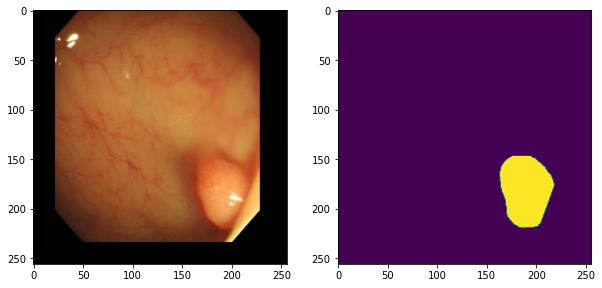

In [17]:
for images, labels in train_dataset.take(1): # train_dataset에서 한 배치(묶음) 가져오기
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))   # 플롯 크기 설정
    img = images[0]  # 배치에서 첫 번째 이미지 선택
 
    plt.subplot(1, 2, 1) # 첫 번째 플롯 (원본 이미지)
    plt.imshow(img) # 이미지 표시

    plt.subplot(1, 2, 2) # 두 번째 플롯 (마스크 이미지)
    plt.imshow(labels[0, :, :, 0])  # 마스크 이미지 표시 (첫 번째 채널만 선택)
    plt.show() # 플롯 보여주기

4-4. Build the model    
오늘 우리는 두 개의 네트워크를 만들어 보고 성능을 비교해 볼 것입니다.   
하나는 Encoder-Decoder 스타일의 네트워크이고, 다른 하나는 U-Net입니다.  

 Encoder-Decoder 네트워크를 구성하여, 이미지 세그멘테이션을 수행할 수 있는 모델을 구축합니다.    
 Encoder는 입력 이미지를 작은 차원으로 압축하고, Decoder는 이를 다시 원래 크기로 복원     
 최종적으로 모델을 결합하고, 예상된 출력이 나오는지 확인하여 모델이 올바르게 구성되었는지 검증  
 
Encoder-Decoder architecture  
Encoder를 이용해 우리가 가진 Train data를 작은 차원의 공간에 압축하는 방식으로 동작합니다. 
Decoder는 Encoder가 압축한 데이터들을 우리가 원하는 label 데이터와 같도록 재생성합니다.   
이렇게 생성된 데이터와 label 간의 차이가 작아지도록 Encoder와 Decoder의 파라미터들이 End-to-End로 학습됩니다.  

Encoder  
- input data의 shape가 다음과 같이 되도록 네트워크를 구성합니다.  
inputs = [batch_size, 256, 256, 3]  
conv1 = [batch_size, 128, 128, 64]  
conv2 = [batch_size, 64, 64, 128]  
conv3 = [batch_size, 32, 32, 256]  
outputs = [batch_size, 16, 16, 512]  

- Convolution - Normalization - Activation 등의 조합을 다양하게 생각해 봅시다.  
- Encoder의 차원을 줄여가는 방법으로 Pooling을 쓸지 Convolution with stride=2 로 할지 선택해 볼 수 있습니다.   
- tf.keras.Sequential()을 이용하여 만들어 봅시다.     

Decoder  
Encoder의 mirror 형태로 만들어 봅시다.  
input data의 shape이 다음과 같이 되도록 네트워크를 구성합니다.  
inputs = encoder의 outputs = [batch_size, 16, 16, 512]  
conv_transpose1 = [batch_size, 32, 32, 256]  
conv_transpose2 = [batch_size, 64, 64, 128]  
conv_transpose3 = [batch_size, 128, 128, 64]  
outputs = [batch_size, 256, 256, 1]  
tf.keras.Sequential()을 이용하여 만들어 봅시다.  

Encoder 구조 만들기  
Encoder는 입력 이미지를 점점 더 작은 차원의 특징 공간으로 압축합니다.   
주로 Convolutional Layer와 Pooling Layer 또는 Strided Convolution을 사용해 이미지를 점점 더 작고 깊은 차원으로 변환합니다.  

In [18]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder') # 순차적으로 레이어를 쌓아올리는 형태

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same')) # 2D 컨볼루션 레이어로, 이미지의 특징을 추출
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same')) #  strides 출력 이미지의 크기를 절반으로 줄입니다, padding 입력과 출력의 크기가 동일하도록 패딩을 추가
encoder.add(layers.BatchNormalization()) # 배치 정규화를 통해 학습을 안정화하고, 학습 속도를 높입니다.
encoder.add(layers.Activation('relu')) # conv1 출력: [batch_size, 128, 128, 64] 비선형 활성화 함수인 ReLU를 적용

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2 출력: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3 출력 : [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs 출력: [batch_size, 16, 16, 512]

In [19]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3])) #  무작위 노이즈 이미지를 생성하여 모델에 입력
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


Decoder 구조 만들기    
Decoder는 Encoder에서 얻은 낮은 차원의 표현을 원래 이미지 크기로 복원하는 역할을 합니다.  
주로 Conv2DTranspose 레이어를 사용해 이미지를 업샘플링합니다.  

In [20]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same')) # 이미지 업샘플링을 위한 전치 컨볼루션 레이어입니다. 이것은 이미지의 크기를 두 배로 늘립니다.
decoder.add(layers.BatchNormalization()) 
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same')) # 복원된 이미지의 세부사항을 더 잘 잡아내기 위해 사용
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid')) # sigmoid : 최종 출력 레이어에서 사용하는 활성화 함수로, 출력을 0과 1 사이로 스케일링하여 이미지 분할의 확률 맵을 생성

In [21]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


Create a encoder-decoder model  
지금까지 Encoder와 Decoder를 잘 만들어 왔다면 이 둘을 결합한 모델은 다음과 같이 간단히 구성할 수 있습니다.  

In [22]:
ed_model = tf.keras.Sequential() # 순차 모델을 사용하여 Encoder와 Decoder를 차례대로 쌓아 결합

ed_model.add(encoder)
ed_model.add(decoder)

 
U-Net architecture  
오늘 우리가 만들어볼 U-Net 모델구조는 아래 그림과 같습니다. 잘 보면 U-Net 원본과는 약간 차이가 있습니다. 논문 원본의 구현에서는 padding을 zero로 하기 때문에 Encoder 레이어 대비 Decoder 레이어에 약간의 사이즈 축소가 발생합니다. 그러나 우리는 padding을 same으로 두고 Encoder, Decoder간 대응하는 레이어의 사이즈를 동일하게 가져갈 것입니다. 이것은 크게 성능에 영향을 주지 않으면서도 구현이 용이할 뿐더러 이후 모델의 추가개선을 더욱 쉽게 만들어 주는 장점이 있습니다.  

Model subclassing을 활용한 구현    
U-Net은 Encoder-Decoder 구조와는 달리 해당 레이어의 outputs이 바로 다음 레이어의 inputs이 되지 않습니다.     
이럴때는 위에 Encoder-Decoder 모델처럼 tf.keras.Sequential()을 쓸 수가 없게 됩니다.    
  
Sequential 구조가 아닌 네트워크를 만들 때 쓸 수 있는 API 가 바로 tf.keras functional API 입니다.    
오늘 우리는 U-Net 구현을 위해 Model subclassing 방식을 사용하여, tf.keras.Model 클래스를 상속하여 구현할 것입니다.     

1. U-Net 모델의 구조 이해  
U-Net은 Encoder-Decoder 아키텍처를 따르는 이미지 분할 모델입니다. 
모델의 이름이 U-Net인 이유는 네트워크 구조가 "U" 모양으로 생겼기 때문입니다.  

Encoder: 입력 이미지를 압축하여 더 작은 차원으로 변환합니다. 이는 이미지의 특징을 추출하는 과정입니다.  
Decoder: Encoder에서 압축된 이미지를 복원하여 원본 크기와 동일한 이미지로 만듭니다.  
Skip Connections: Encoder에서 얻은 특징 맵을 Decoder에 전달하여 더 나은 복원을 가능하게 합니다.  

2. Model Subclassing을 이용한 U-Net 구현  
U-Net 모델을 구현하기 위해 Model Subclassing 방식을 사용합니다.    
Model Subclassing은 복잡한 네트워크 구조를 쉽게 구현할 수 있는 방법으로, tf.keras.Model 클래스를 상속받아 모델을 만듭니다.  



주요 구성 요소 코드 설명    
1) Conv 클래스    

단일 Convolutional 블록을 정의하는 클래스입니다.    
Conv2D → BatchNormalization → ReLU 활성화로 구성됩니다.    

In [23]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

2) ConvBlock 클래스  

두 개의 Conv 레이어를 포함한 블록을 정의합니다.  
일반적으로 Encoder에서 사용됩니다.   

3) ConvBlock_R 클래스
두 개의 Conv 레이어로 구성된 컨볼루션 블록을 정의합니다.  
디코더에서 사용되기 때문에, 인코더의 출력을 점차 복원하는 역할

4) EncoderBlock 클래스  
  
ConvBlock과 MaxPooling 레이어로 구성된 블록입니다.  
Encoder에서 이미지를 점점 더 작은 크기로 압축합니다.   

5) DecoderBlock 클래스  
  
Conv2DTranspose를 사용하여 이미지 크기를 확대합니다.   
Encoder의 특징 맵을 복원하는 역할을 합니다.   

6) UNet 클래스  
  
전체 U-Net 모델 구조를 정의합니다.  
Encoder 블록, Center 블록, Decoder 블록을 모두 포함합니다.  

In [24]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters): # 각 컨볼루션 레이어에 사용할 필터의 개수
        super(ConvBlock_R, self).__init__()
        # self.conv1과 self.conv2는 모두 Conv 클래스를 사용하여 정의된 컨볼루션 레이어입니다. 각 레이어는 3x3 커널을 사용
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    # 입력을 받아 디코더의 각 레이어를 순차적으로 적용    
    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)    # 첫 번째 Conv 레이어를 거친 결과를 `decoder`에 저장 , 출력은 활성화 함수(ReLU)와 배치 정규화(Batch Normalization)까지 거칩니다.
        decoder = self.conv2(decoder, training=training)   # 두 번째 Conv 레이어를 거친 결과를 `decoder`에 저장

        return decoder  # 두 개의 컨볼루션 레이어를 통과한 출력을 반환


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [25]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

Create a U-Net model  
위에서 구현한 Class들을 생성해 최종적으로 U-net 모델을 구현해 줍시다.  

In [26]:
unet_model = UNet()

metrics과 loss functions 정의하기  
우리가 사용할 loss function은 다음과 같습니다.  
 
binary cross entropy  

dice_loss   
Image Segmentation Task에서 정답을 더 잘 찾아내기위해 새로운 Loss를 추가해 사용한다.  
논문에 나온 Dice coefficient 수식   
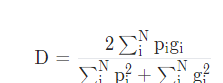
Cross-entropy loss와 Dice loss를 같이 사용해 meanIoU를 더 올리도록 학습할 수 있다.  

특별한 손실 함수(Loss Function) 정의  
이미지 분할 모델의 성능을 더 잘 평가하기 위해 Dice 손실 함수를 정의합니다.   
Dice 손실 함수는 모델이 예측한 영역과 실제 영역이 얼마나 잘 겹치는지를 평가합니다.  

In [27]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [28]:
#Dice Loss가 최대화되는 방향으로 구해지도록, 아래와 같이 사용합니다.
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [29]:
# 새로운 Loss function을 사용하기위해서 기존에 사용하였던 Binary crossentropy loss와 새로 구현한 Dice loss를 더하는 방식으로 구성합니다.
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss


모델 컴파일 및 체크포인트 저장 설정   
모델을 컴파일하고 학습 도중 특정 조건을 만족할 때 모델을 저장할 수 있도록 설정합니다.  

In [30]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

In [31]:
# Select a model
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요. 
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다. 

#print('select the Encoder-Decoder model')
#model = ed_model
#checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

print('select the U-Net model')
model = unet_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')


select the U-Net model


In [32]:
# Compile

model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [33]:
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

Callbacks  
Callback 함수들을 이용하여, 학습 중간에 원하는 동작을 할 수 있도록 합니다.    
ModelCheckpoint callback 함수는 모델 학습간 특정 feature를 모니터링하다 기준점을 넘으면 모델 파라미터를 저장하는 역할을 합니다.  
LearningRateScheduler callback 함수는 학습을 진행하며, 주어진 인자의 값을 이용해 Learning rate를 조절해주는 함수입니다.  
cos_decay는 cos 함수의 모양으로 Learning rate를 조절해 주는 learning rate decay 구현입니다.  

In [34]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [35]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

4-5. Train your model  
모델 학습 이전에, 모델에서 예측한 이미지를 출력할 수 있는 함수를 미리 작성해 모델 성능 테스트에 사용합니다.

In [36]:
## Define print function
# 테스트 데이터셋에서 이미지를 가져와서 모델의 예측 결과를 시각화합니다. 
# 입력 이미지와 실제 마스크, 그리고 모델이 예측한 마스크를 나란히 출력하여 모델의 성능을 직관적으로 확인
def print_images():
    # test_dataset에서 1개의 배치를 가져와서 예측한 결과를 시각화합니다.
    for test_images, test_labels in test_dataset.take(1):
        # 모델을 사용하여 예측을 수행합니다.
        predictions = model(test_images, training=False)

        # 이미지를 시각화합니다.
        plt.figure(figsize=(10, 20))
        
        # 입력 이미지 출력
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0, :, :, :])  # 첫 번째 이미지
        plt.title("Input image")  # 제목 설정

        # 실제 마스크 출력
        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])  # 첫 번째 이미지의 실제 마스크
        plt.title("Actual Mask")  # 제목 설정

        # 예측한 마스크 출력
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])  # 첫 번째 이미지에 대한 예측 마스크
        plt.title("Predicted Mask")  # 제목 설정

        # 그래프를 화면에 출력합니다.
        plt.show()


Training - model.fit() 함수 이용    
학습을 진행하며, 위에서 구성한 Train dataset과 Test dataset등을 이용해 학습을 진행합니다.   
학습 데이터의 갯수가 부족하기때문에 Test dataset을 Validation dataset으로 사용할 것입니다.    
아래는 model를 학습하는 코드입니다. 10 Epoch만 학습을 진행한 후, 미리 학습된 모델을 불러올 예정입니다.    

In [37]:
# 모델 학습을 위한 설정
history = model.fit(
    train_dataset,  # 학습 데이터셋
    epochs=max_epochs,  # 총 학습 epoch 수 (여기서는 10)
    steps_per_epoch=num_train_examples // batch_size,  # 한 epoch 당 실행할 스텝 수
    validation_data=test_dataset,  # 검증 데이터셋으로 테스트 데이터 사용
    validation_steps=num_test_examples // batch_size,  # 한 epoch당 검증 단계에서 실행할 스텝 수
    callbacks=[cp_callback, lr_callback]  # 콜백 함수를 사용하여 체크포인트 저장 및 학습률 스케줄링
)



Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 37s 857ms/step - loss: 1.0415 - dice_loss: 0.7283 - val_loss: 1730.2786 - val_dice_loss: 0.9148
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 27s 857ms/step - loss: 0.9252 - dice_loss: 0.7021 - val_loss: 236.0757 - val_dice_loss: 1.0000
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 27s 871ms/step - loss: 0.9164 - dice_loss: 0.6980 - val_loss: 17.3260 - val_dice_loss: 0.9052
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 28s 880ms/step - loss: 0.9048 - dice_loss: 0.6936 - val_loss: 1.9424

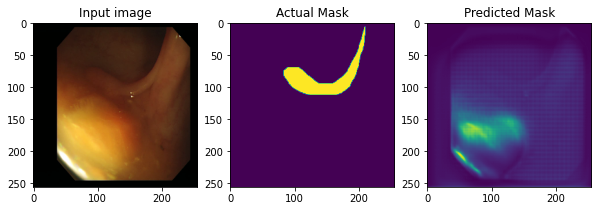

In [39]:
# print sample image after training 
# 학습 후 샘플 이미지를 출력하여 학습된 결과를 시각적으로 확인
print_images() 

Plot the loss  
저장된 학습 진행과정(history)을 시각화해 봅시다.  

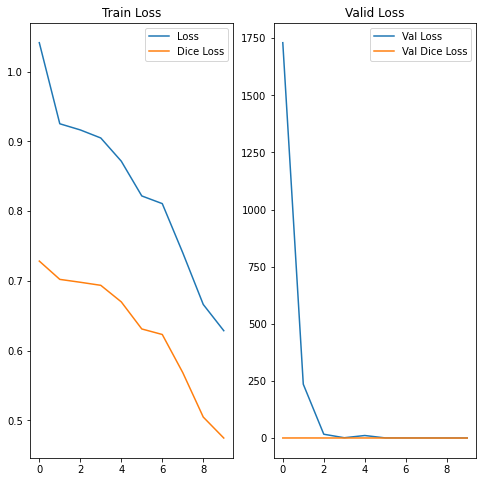

In [40]:
#  손실 함수 및 평가 메트릭 시각화
#  학습 및 검증 손실(history)을 시각화합니다.
#  학습 과정에서의 손실 함수와 Dice 손실을 시각화합니다. 학습과 검증 단계에서의 손실 변화를 통해 모델의 학습 진전을 평가 가능.
dice_loss = history.history['dice_loss']  # 학습 동안 계산된 dice loss
loss = history.history['loss']  # 학습 동안 계산된 전체 손실
val_dice_loss = history.history['val_dice_loss']  # 검증 동안 계산된 dice loss
val_loss = history.history['val_loss']  # 검증 동안 계산된 전체 손실

epochs_range = range(max_epochs)  # 에포크 수 범위 생성

plt.figure(figsize=(8, 8))

# 학습 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')  # 손실 값
plt.plot(epochs_range, dice_loss, label='Dice Loss')  # Dice 손실 값
plt.legend(loc='upper right')
plt.title('Train Loss')

# 검증 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')  # 검증 손실 값
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')  # 검증 Dice 손실 값
plt.legend(loc='upper right')
plt.title('Valid Loss')

# 그래프를 화면에 출력
plt.show()


Restore the latest checkpoint  
저장된 모델의 가중치를 불러옵니다. ed_ckpt나 unet_ckpt에 담긴 것이 미리 학습시킨 모델입니다.     
직접 학습시킨 모델은 train_ckpt에 있습니다. 원하는 모델을 불러와 사용하세요.    

지정된 경로에서 모델의 최신 가중치를 복원합니다. 이를 통해 학습된 모델의 상태를 복원하고 이후 테스트 및 예측에 사용  

In [41]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
# checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
#  최신 체크포인트 복원

checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir 지정된 디렉토리에서 최신 가중치를 로드
model.load_weights(checkpoint_dir)

Evaluate the test dataset  
불러온 가중치를 이용해서 모델을 평가해 봅시다.   
meanIoU를 metric으로 하여 정량적으로 평가해 볼 수 있고, 실제 생성된 segmentation 이미지를 분석해서 정성적으로 평가해 볼 수 있습니다.  

meanIoU란 각 이미지의 IoU 값을 평균 낸 값입니다. IoU는 segmentation 모델을 정량적으로 평가하는데 좋은 metric이 됩니다.   
개념은 아래 그림과 같습니다.       

 모델의 예측 성능을 평가하기 위해 평균 Intersection over Union (IoU) 값을 계산합니다.
 IoU는 이미지 세그멘테이션 문제에서 자주 사용되는 메트릭으로, 예측된 영역과 실제 영역 간의 겹치는 정도를 측정  

In [42]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten: 1차원 배열로 변환
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # Float 값을 가진 텐서를 정수형 텐서로 변환하여 0과 1로 구성된 이진화된 결과를 얻음
    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # Confusion matrix 계산
    labels = list(range(num_classes))  # 클래스 레이블 리스트 생성 (여기선 0과 1)
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # IoU 계산을 위한 변수 설정
    intersection = np.diag(current)  # 교집합: Confusion matrix의 대각 성분
    ground_truth_set = current.sum(axis=1)  # 실제 값의 합 (TP + FN)
    predicted_set = current.sum(axis=0)  # 예측 값의 합 (TP + FP)
    union = ground_truth_set + predicted_set - intersection  # 합집합: TP + FP + FN

    # IoU 계산
    IoU = intersection / union.astype(np.float32)  # 교집합을 합집합으로 나눔
    return np.mean(IoU)  # 모든 클래스에 대한 IoU의 평균값 반환


테스트 데이터셋을 불러와서 meanIoU 값을 구해 봅시다. 이 값이 우리가 훈련시킨 모델에 대한 정량적 성능 metric이 됩니다.

테스트 데이터셋 평가


In [43]:
# Mean IoU를 계산하여 모델의 성능을 평가합니다.
mean = []

# 테스트 데이터셋을 반복하여 각 배치에 대해 Mean IoU를 계산
for images, labels in test_dataset:
    predictions = model(images, training=False)  # 모델의 예측 수행
    m = mean_iou(labels, predictions)  # Mean IoU 계산
    mean.append(m)  # Mean IoU 값을 리스트에 추가

mean = np.array(mean)  # 리스트를 numpy 배열로 변환
mean = np.mean(mean)  # 전체 평균 IoU 계산
print("mean_iou: {}".format(mean))  # Mean IoU 출력


mean_iou: 0.9381448561518053


Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 직접 확인해 봅시다. 
예측 이미지 출력 함수  

In [44]:
# 모델의 예측 결과를 시각적으로 확인합니다.
def print_images():
    # test_dataset에서 1개의 배치를 가져와서 예측한 결과를 시각화합니다.
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)  # 모델의 예측 수행

        # 각 배치에 있는 모든 이미지에 대해 예측 결과를 시각화합니다.
        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            
            # 입력 이미지 출력
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i, :, :, :])  # i번째 입력 이미지
            plt.title("Input image")  # 제목 설정

            # 실제 마스크 출력
            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])  # i번째 실제 마스크
            plt.title("Actual Mask")  # 제목 설정

            # 예측한 마스크 출력
            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])  # i번째 예측 마스크
            plt.title("Predicted Mask")  # 제목 설정

            # 그래프를 화면에 출력
            plt.show()



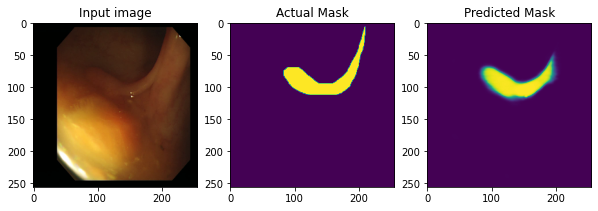

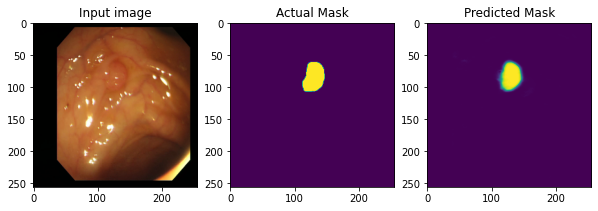

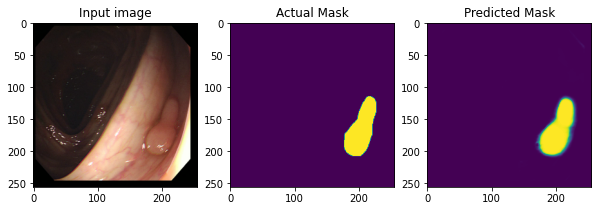

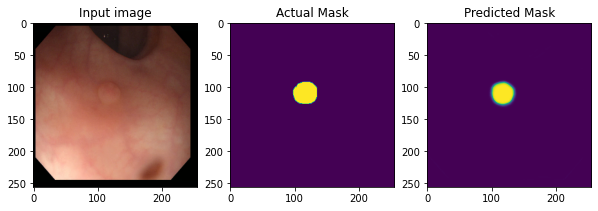

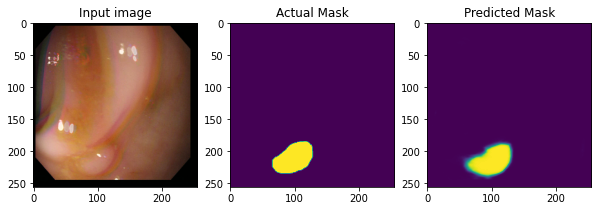

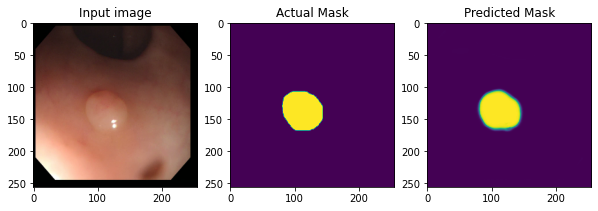

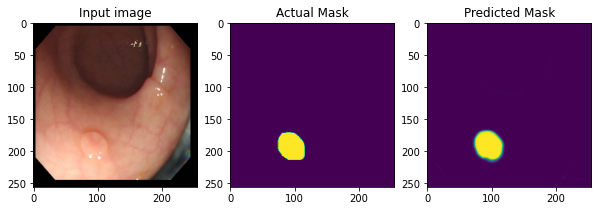

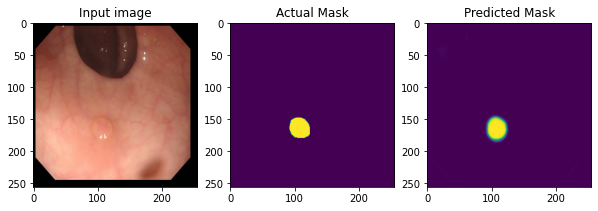

In [45]:
# 위에서 정의한 함수를 사용하여 예측 결과를 출력
print_images()


# 4-6. 프로젝트: U-Net 성능 개선해 보기  
지금까지 우리는 Encoder-Decoder 모델과 U-Net 모델의 성능 차이를 실험을 통해 살펴보았습니다.   
아마도 여러분들은 의료영상 Segmentation 모델을 위해 U-Net을 고려할 가치가 충분하다는 것을 확인할 수 있었을 것입니다.  

그러나 이를 개선할 수 있는 방법 또한 무궁무진합니다.  
U-Net 또한 개선을 거듭해 왔고, 또 U-Net 기반이 아닌 다른 모델들도 많이 나오고 있습니다.  

혹시, U-Net의 인코더 모델을 VGG, ResNet 등 기존의 pretrained model을 활용하는 것은 가능할까요?  
또 그런 시도를 했을 때 성능 개선 효과가 있을까요?  
Pretrained model들은 ImageNet 데이터를 이용해 pretrain된 것이 대부분입니다. 일반적으로는 transfer learning이 훨씬 효과적인 것으로 알려져 있지만, 의료 영상 도메인에도 동일하게 효과적일까요? 오늘의 프로젝트는 그것을 확인해 보는 것으로 하겠습니다.  

우선 주요 라이브러리 버전을 확인해 봅시다.  

In [46]:
import tensorflow
import sklearn
import numpy

print(tensorflow.__version__)
print(sklearn.__version__)
print(numpy.__version__)

2.6.0
1.0
1.21.4


STEP 1 : 데이터셋 구성  
오늘 실습에서 활용하였던 Giana 데이터셋을 그대로 활용하여, augmentation을 위한 파이프라인 구성 및 tf.data.Dataset을 이용한 배치처리를 통해 학습/테스트 데이터셋을 구성합니다.  

1. 데이터셋 로드 및 경로 설정   
우선, 사용할 데이터셋의 경로를 설정하고 데이터를 로드합니다.  

In [47]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Giana 데이터셋 경로 설정
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')
img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

# 이미지와 레이블 파일 경로 리스트 생성
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]

# 파일 이름 정렬
x_train_filenames.sort()
y_train_filenames.sort()

# 학습 및 테스트 데이터 분리
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = train_test_split(
    x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples:", num_train_examples)
print("Number of test examples:", num_test_examples)


Number of training examples: 240
Number of test examples: 60


2. 이미지 로드 및 전처리 함수 정의  
이전과 비슷하게 이미지와 레이블을 로드하고 전처리하는 함수를 작성합니다.  

In [48]:
# 이미지와 레이블 로드 및 전처리 함수
def _process_pathnames(fname, label_path):
    # 이미지 파일 로드 및 BMP 디코딩
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    # 레이블 이미지 파일 로드 및 BMP 디코딩
    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    # 이미지 및 레이블 크기 조정
    resize = [256, 256]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    # 이미지 정규화
    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img


3. Data Augmentation 함수 정의  
Data augmentation을 위한 함수를 작성합니다. 이 함수에서는 이미지의 좌우 반전, 위치 이동 등을 포함하여 여러 가지 변환을 적용합니다.  

In [49]:
# Data augmentation 함수
def _augment(img,
             label_img,
             resize=None,
             scale=1,
             hue_delta=0.1,
             horizontal_flip=True,
             width_shift_range=0.1,
             height_shift_range=0.1):
    if resize is not None:
        # 이미지 및 레이블 크기 조정
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        # 이미지 색조 조정
        img = tf.image.random_hue(img, hue_delta)
  
    if horizontal_flip:
        # 이미지 및 레이블 좌우 반전
        img = tf.image.flip_left_right(img)
        label_img = tf.image.flip_left_right(label_img)
  
    # 이미지 및 레이블 위치 이동
    if width_shift_range or height_shift_range:
        width_shift_range = tf.random.uniform([], -width_shift_range, width_shift_range)
        height_shift_range = tf.random.uniform([], -height_shift_range, height_shift_range)
        img = tfa.image.translate(img, [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img, [width_shift_range, height_shift_range])

    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    return img, label_img


4. tf.data.Dataset을 이용한 데이터셋 구성
tf.data.Dataset을 사용하여 배치 처리 및 augmentation을 포함한 데이터셋을 구성합니다.

In [50]:
# 데이터셋 구성 함수
def get_baseline_dataset(filenames, labels, batch_size=8, is_train=True):
    num_x = len(filenames)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_process_pathnames, num_parallel_calls=tf.data.AUTOTUNE)

    if is_train:
        dataset = dataset.map(_augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=num_x)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# 학습 및 테스트 데이터셋 생성
batch_size = 8
train_dataset = get_baseline_dataset(x_train_filenames, y_train_filenames, batch_size=batch_size, is_train=True)
test_dataset = get_baseline_dataset(x_test_filenames, y_test_filenames, batch_size=batch_size, is_train=False)


5. 데이터셋 시각화
Data augmentation이 잘 적용되었는지 확인하기 위해 일부 이미지를 시각화합니다.

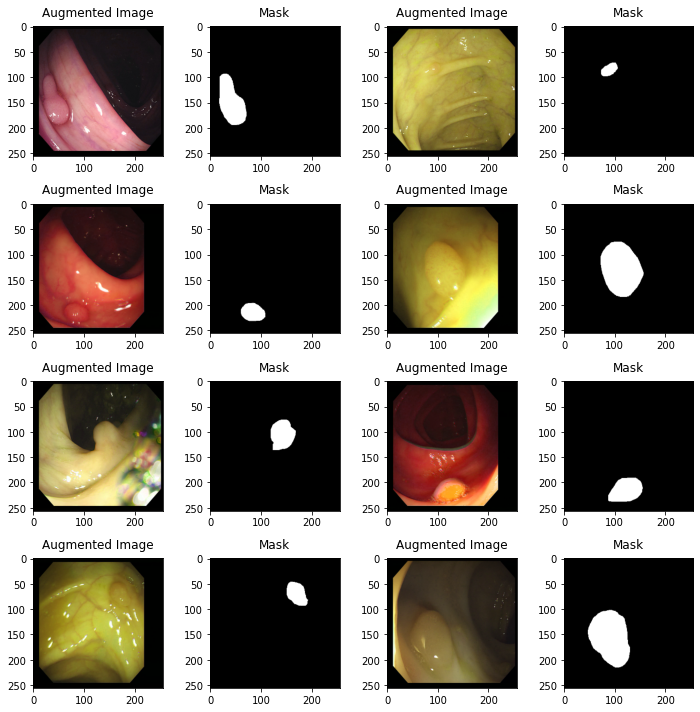

In [51]:
# 학습 데이터 시각화
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(batch_size):
        plt.subplot(4, 4, i * 2 + 1)
        plt.imshow(images[i])
        plt.title("Augmented Image", pad=10)  # Add padding to the title
        
        plt.subplot(4, 4, i * 2 + 2)
        plt.imshow(labels[i, :, :, 0], cmap='gray')
        plt.title("Mask", pad=10)  # Add padding to the title
        
    plt.tight_layout()  # Adjust subplot params for better layout
    plt.show()


STEP 2 : pretrained model을 활용한 U-Net 모델 구성  
Encoder를 pretrained 모델로 변경하는 작업을 어떻게 진행하면 좋을까요? 아래 예시는 VGG16을 활용하기 위한 것입니다. 마음에 드는 다른 모델을 활용하기 위해 다양하게 시도해 보는 것을 권장합니다.  

우선 VGG16 모델의 레이어 구성을 확인해 봅시다. U-Net이란 Encoder와 Decoder 사이의 대응되는 레이어간의 skip connection이 특징인 모델입니다. 여기서 Encoder를 pretrained model로 바꿔주려면 Encoder로 활용할 모델의 레이어 구성을 눈여겨 봐야겠죠?  

VGG16을 Encoder로 활용한 U-Net 모델 구성  
1. VGG16 모델의 레이어 구성을 확인하기  
먼저, VGG16 모델을 불러와서 그 구조를 확인합니다.    
VGG16은 ImageNet 데이터셋으로 사전 학습된 모델로, 다양한 이미지 분류 작업에서 성능이 검증된 모델입니다.  

In [52]:
# VGG16 모델을 불러와 인코더로 사용
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,  # 입력 이미지 크기
                                         include_top=False, # 최상위 분류기 부분 제거
                                         weights='imagenet')  # ImageNet 데이터셋으로 학습된 가중치 사용

# VGG16 모델의 레이어 출력 가져오기    
layer_outputs = [layer.output for layer in vgg16.layers]
# 레이어 출력 확인  
layer_outputs 

[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'block3_pool')>,


VGG16의 경우 모델구성이 특히나 U-Net의 그것과 닮았다는 것을 알수 있습니다. 반드시 그래야 하는 것은 아니지만 이렇게 모델 구조가 유사하면 결합하여 사용하기에 유리할 것입니다.

아래는 VGG16을 Encoder로 활용하여 개선한 새로운 모델 클래스입니다. 이 모델을 구성하기 위해서 내부에서 새로운 모델(vgg16_act)을 만들었는데, 이것은 VGG16의 특정 레이어 출력을 가져와 Decoder와 연결하기 위한 것입니다. 기존 UNet 클래스와 비교하면, encoder 레이어가 없어지고 vgg16_act 모델의 출력이 그 역할을 대신하고 있음을 알수 있습니다
  
2. VGG16을 인코더로 사용한 새로운 U-Net 모델 클래스 정의  
이제 VGG16을 인코더로 활용하는 새로운 U-Net 모델 클래스를 정의합니다.   
이 모델은 기존의 U-Net 구조에서 인코더 부분을 VGG16으로 대체한 것입니다.  

In [53]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        
        # VGG16 모델 불러오기
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        # 필요한 레이어 출력만 가져오기
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])

        # 기존 U-Net의 Center 블록 및 Decoder 블록 정의
        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)
        # 최종 출력 레이어 (1x1 Convolution, Sigmoid 활성화 함수)
        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
         # VGG16의 인코더 출력
        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 
        # 각 단계의 디코더 블록과 인코더 출력 연결 (Skip connection)
        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        # 최종 출력 계산
        outputs = self.output_conv(decoder1)

        return outputs

3. U-Net 모델 학습 준비 
모델 학습을 위해 아래와 같이 모델을 컴파일하고 학습을 시작할 수 있습니다. 

In [57]:
#  pretrained 모델에 대한 새로운 손실 함수를 정의
import tensorflow as tf

# 손실 함수 정의
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + tf.reduce_sum(tf.square(y_pred_f)) + smooth)
    return score

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    binary_crossentropy = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    loss = tf.reduce_mean(binary_crossentropy) + dice_loss(y_true, y_pred)
    return loss

# U-Net 모델 컴파일
unet_model.compile(optimizer='adam',
                   loss=bce_dice_loss,
                   metrics=[dice_loss])

# 모델 학습 실행
history = unet_model.fit(train_dataset,
                         epochs=max_epochs,
                         steps_per_epoch=num_train_examples // batch_size,
                         validation_data=test_dataset,
                         validation_steps=num_test_examples // batch_size,
                         callbacks=[cp_callback, lr_callback])


Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 27s 577ms/step - loss: 1.0492 - dice_loss: 0.7193 - val_loss: 120.7396 - val_dice_loss: 0.9055
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 19s 572ms/step - loss: 0.8326 - dice_loss: 0.6217 - val_loss: 2.7270 - val_dice_loss: 0.9306
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 19s 581ms/step - loss: 0.7315 - dice_loss: 0.5500 - val_loss: 1.7703 - val_dice_loss: 1.0000
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 19s 588ms/step - loss: 0.6536 - dice_loss: 0.4937 - val_loss: 1.2709 - v

STEP 3: 학습과 테스트, 시각화  
모델을 변경하여 실습과정과 동일하게 학습과 테스트, 시각화를 진행합니다.  
      
1. 모델 학습하기    
학습 데이터를 사용하여 모델을 훈련합니다. 학습 과정에서는 우리가 정의한 손실 함수와 메트릭을 사용해 모델의 성능을 평가합니다.    

In [58]:
# 모델 학습
history = unet_model.fit(
    train_dataset,
    epochs=max_epochs,  # 설정한 에포크 수
    steps_per_epoch=num_train_examples // batch_size,
    validation_data=test_dataset,
    validation_steps=num_test_examples // batch_size,
    callbacks=[cp_callback, lr_callback]  # 학습 중 체크포인트 저장 및 학습률 조절
)


Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 18s 558ms/step - loss: 0.5400 - dice_loss: 0.4064 - val_loss: 2.7394 - val_dice_loss: 0.8482
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 18s 567ms/step - loss: 0.5200 - dice_loss: 0.3933 - val_loss: 1.9627 - val_dice_loss: 0.8268
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 19s 578ms/step - loss: 0.4302 - dice_loss: 0.3205 - val_loss: 1.2341 - val_dice_loss: 0.7879
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 19s 586ms/step - loss: 0.4377 - dice_loss: 0.3295 - val_loss: 0.6192 - val

2. 모델 학습 결과 시각화  
학습 과정에서 저장된 손실(loss) 및 Dice loss 등을 그래프로 시각화하여 모델의 학습 성능을 평가합니다.  

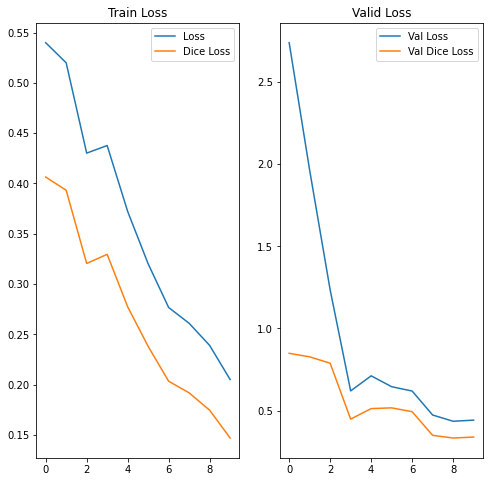

In [59]:
# 학습 손실 및 Dice loss 시각화
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()


3. 모델 평가하기
저장된 모델 가중치를 불러와 테스트 데이터셋을 사용하여 모델을 평가합니다.

In [60]:
# Checkpoint 디렉토리 설정
checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')

# Checkpoint 불러오기
model.load_weights(checkpoint_dir)

# 테스트 데이터셋에 대한 모델 평가
mean = []
for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print(f"Mean IoU: {mean}")


Mean IoU: 0.9450264339249993


4. 테스트 결과 시각화
테스트 데이터에 대한 모델의 예측 결과를 시각화하여 모델의 예측이 얼마나 정확한지 시각적으로 확인합니다.

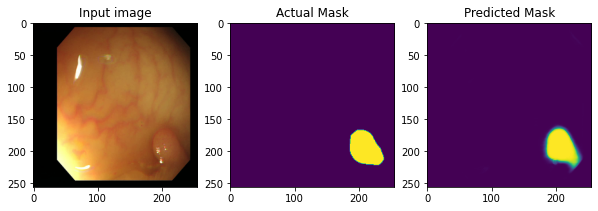

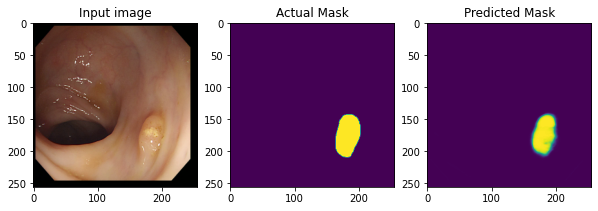

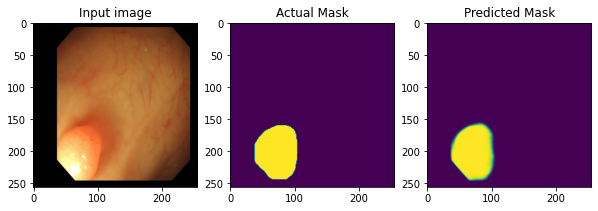

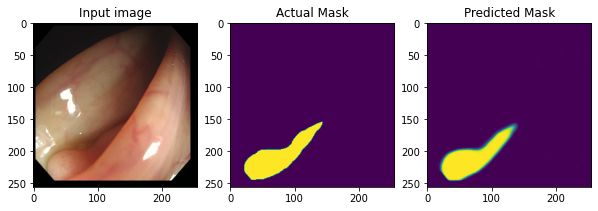

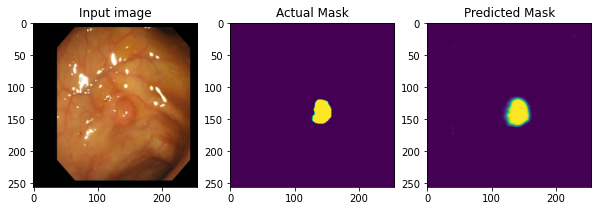

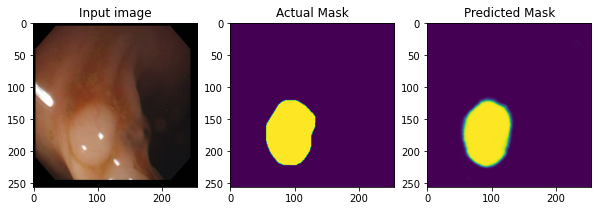

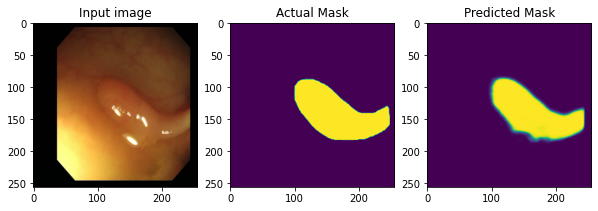

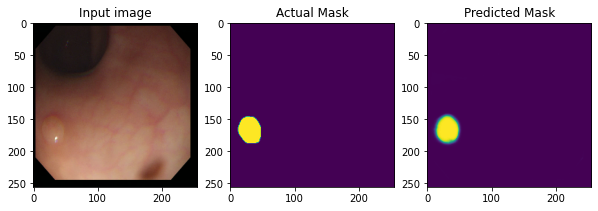

In [61]:
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

print_images()
